In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\reid-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset_omniglot = torchvision.datasets.Omniglot('./data/omniglot',
                                                 transform=transform)
dataset_train = reid.datasets.paired.TriplePairedVisionDataset(
    dataset_omniglot)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=256,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.resnet18_custom(True)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.to(device)
criterion = torch.nn.TripletMarginLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Train
losses = []
num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, batch in enumerate(dataloader_train, 0):
        inputs_anchor, inputs_positive, inputs_negative = batch
        inputs_anchor = inputs_anchor.to(device)
        inputs_positive = inputs_positive.to(device)
        inputs_negative = inputs_negative.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_anchor = model(inputs_anchor)
        outputs_positive = model(inputs_positive)
        outputs_negative = model(inputs_negative)
        loss: torch.Tensor = criterion(outputs_anchor, outputs_positive,
                                       outputs_negative)
        loss.backward()
        optimizer.step()

        # print statistics

    print(f'epoch: {epoch}, loss: {loss}')
    losses.append(loss)

    if epoch % 10 == 9:
        torch.save(model.state_dict(), "./triplet_epoch_{}.pth".format(epoch))

epoch: 0, loss: 0.18942390382289886
epoch: 1, loss: 0.19584663212299347
epoch: 2, loss: 0.26797860860824585
epoch: 3, loss: 0.12305351346731186
epoch: 4, loss: 0.19723963737487793
epoch: 5, loss: 0.1963454931974411
epoch: 6, loss: 0.14710639417171478
epoch: 7, loss: 0.058036159723997116
epoch: 8, loss: 0.49807009100914
epoch: 9, loss: 0.14303205907344818
epoch: 10, loss: 0.17987200617790222
epoch: 11, loss: 0.108864426612854
epoch: 12, loss: 0.1397608518600464
epoch: 13, loss: 0.13704517483711243
epoch: 14, loss: 0.10437959432601929
epoch: 15, loss: 0.22812874615192413
epoch: 16, loss: 0.17689751088619232
epoch: 17, loss: 0.21545279026031494
epoch: 18, loss: 0.22664587199687958
epoch: 19, loss: 0.07235080748796463
epoch: 20, loss: 0.11873050034046173
epoch: 21, loss: 0.23459182679653168
epoch: 22, loss: 0.06881962716579437
epoch: 23, loss: 0.06921415776014328
epoch: 24, loss: 0.18089734017848969


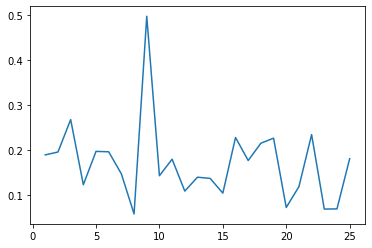

In [7]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), losses)
plt.show()

In [9]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch
    anchors, positives, negatives = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        positive = positives[i].unsqueeze(dim=0).to(device)
        negative = negatives[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_positive = model(positive)
        output_negative = model(negative)
        distance_positive = torch.nn.functional.pairwise_distance(
            output_anchor, output_positive)
        distance_negative = torch.nn.functional.pairwise_distance(
            output_anchor, output_negative)

        # make grid
        imgs = torch.cat(
            (transform(anchor), transform(positive), transform(negative)), 0)
        plt.imshow(torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'p: {:.2f}, n: {:.2f}'.format(distance_positive.item(),
                                               distance_negative.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

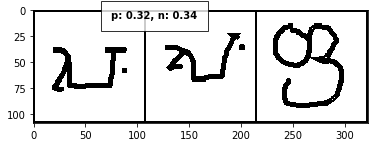

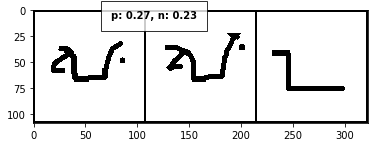

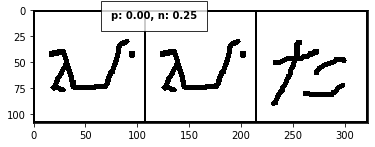

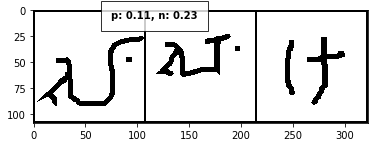

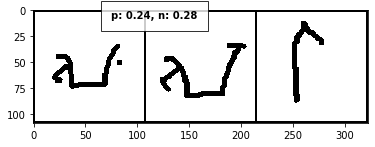

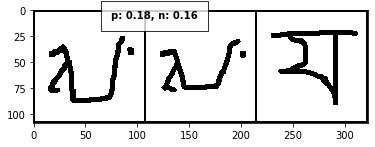

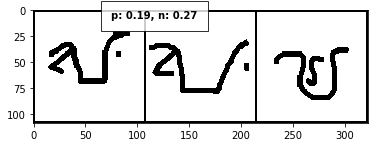

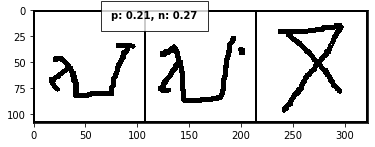

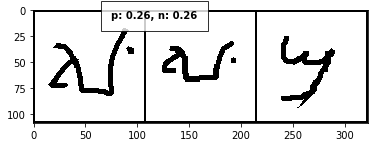

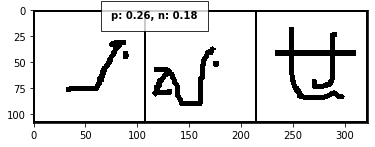

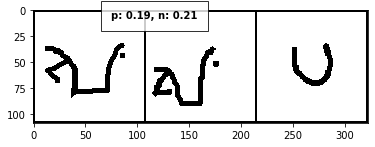

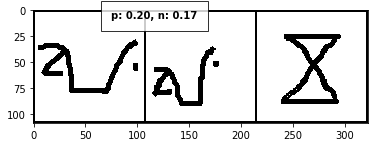

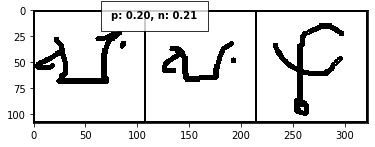

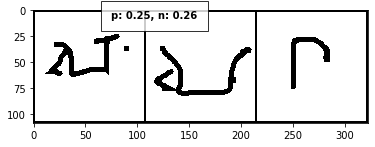

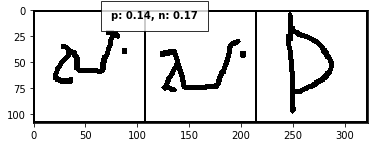

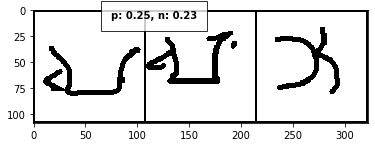

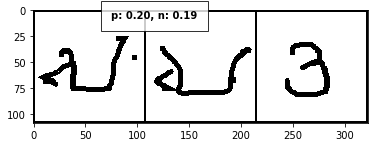

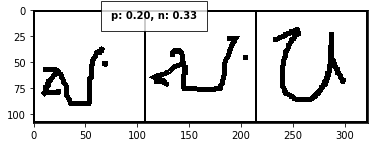

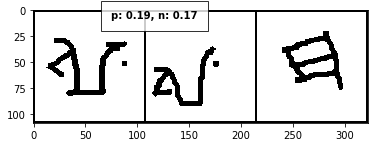

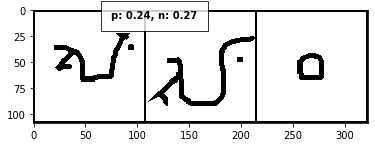

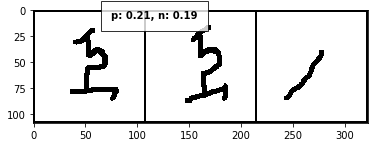

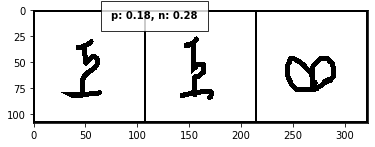

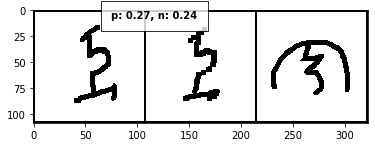

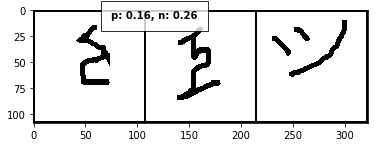

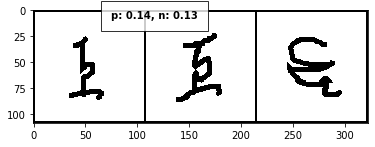

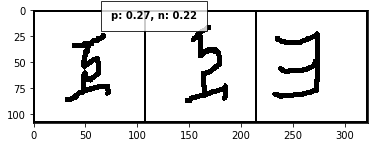

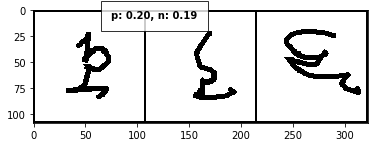

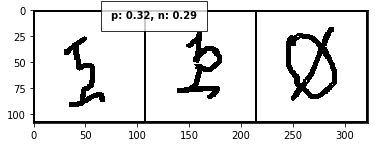

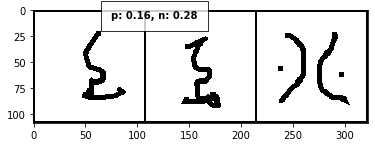

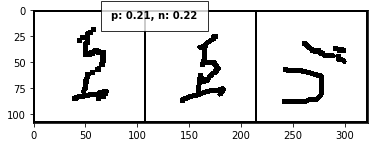

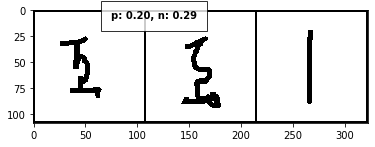

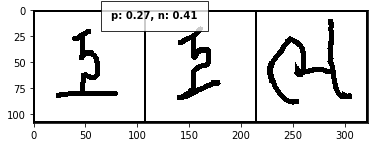

In [11]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)